In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import tiktoken

In [2]:
enc = tiktoken.get_encoding("o200k_base")

In [3]:
# with open('results/fanoutqa_dev_agg.json', 'r') as f:
with open('results/frames_agg.json', 'r') as f:
    data = json.load(f)

print(f"Number of records: {len(data)}")
print("\nFirst record keys:", list(data[0].keys()))

Number of records: 549

First record keys: ['navigator_output', 'aggregated_output', 'langchain_messages', 'aggregator_messages', 'time', 'id', 'gold_answer', 'question', 'wiki_errors']


In [4]:
def extract_langchain_messages(data_item):
    messages = []
    for d in data_item.get("langchain_messages", []):
        if d.startswith("{"):
            try:
                messages.append(json.loads(d))
            except json.JSONDecodeError:
                messages.append(d)
    return messages

extract_langchain_messages(data[0])

[{'thoughts': {'text': "I need to start by identifying the 15th First Lady of the United States to find out her mother's name.",
   'reasoning': "Finding the 15th First Lady will give me the first name I need, which is the first step in answering the user's query.",
   'plan': "- Search for the 15th First Lady of the United States\n- Extract the relevant information about her mother\n- Search for the second assassinated president and extract information about his mother's maiden name",
   'criticism': "I need to ensure I'm breaking down the query correctly and gathering information step by step.",
   'speak': "I'll start by searching for the 15th First Lady of the United States to find her mother's name."},
  'command': {'name': 'search',
   'args': {'tool_input': '15th First Lady of the United States'}}},
 {'thoughts': {'text': "I need to gather information about the 15th First Lady of the United States and the second assassinated president to solve the query regarding my future wife'

In [5]:
len_messages = [len(extract_langchain_messages(d)) for d in data]
np.mean(len_messages)

18.775956284153004

In [6]:
def extract_aggregated_messages(data_item):
    messages = []
    for d in data_item.get("aggregator_messages", []):
        for k, v in d.items():
            if "log" in k:
                messages.append(str(v))
    return messages


extract_aggregated_messages(data[0])

['{\'thoughts\': "The content provides information about Lady Bird Johnson, including her role as the First Lady of the United States and details about her family, specifically her mother\'s name.", \'paragraphs\': [\'Claudia Alta "Lady Bird" Johnson (née Taylor; December 22, 1912 – July 11, 2007) was the first lady of the United States from 1963 to 1969 as the wife of President Lyndon B. Johnson. She served as the second lady from 1961 to 1963 when her husband was vice president.\', \'Her mother was Minnie Lee Pattillo (1874–1918), who loved opera and felt out of place in Karnack; she was often in poor emotional and physical health. When Lady Bird was five years old, Minnie fell down a flight of stairs while pregnant and died of complications of miscarriage in 1918.\']}',
 '{\'thoughts\': "The provided information identifies the 15th First Lady of the United States, Claudia Alta \'Lady Bird\' Johnson, and also gives the name of her mother, Minnie Lee Pattillo. This is relevant because

In [7]:
def get_all_text(data_item):
    messages = extract_langchain_messages(data_item)
    messages += extract_aggregated_messages(data_item)
    messages += data_item["navigator_output"] if data_item.get("navigator_output") else []
    messages += data_item["aggregated_output"] if data_item.get("aggregated_output") else []
    messages_text = "\n".join(map(str, messages))
    return messages_text

get_all_text(data[0])

'{\'thoughts\': {\'text\': "I need to start by identifying the 15th First Lady of the United States to find out her mother\'s name.", \'reasoning\': "Finding the 15th First Lady will give me the first name I need, which is the first step in answering the user\'s query.", \'plan\': "- Search for the 15th First Lady of the United States\\n- Extract the relevant information about her mother\\n- Search for the second assassinated president and extract information about his mother\'s maiden name", \'criticism\': "I need to ensure I\'m breaking down the query correctly and gathering information step by step.", \'speak\': "I\'ll start by searching for the 15th First Lady of the United States to find her mother\'s name."}, \'command\': {\'name\': \'search\', \'args\': {\'tool_input\': \'15th First Lady of the United States\'}}}\n{\'thoughts\': {\'text\': "I need to gather information about the 15th First Lady of the United States and the second assassinated president to solve the query regardi

In [8]:
len(enc.encode(get_all_text(data[0])))

4624

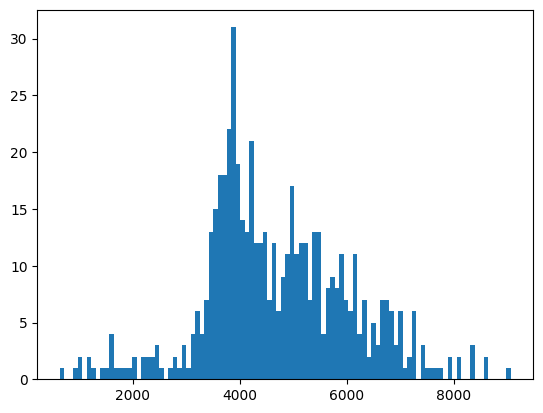

In [9]:
lengths = [len(enc.encode(get_all_text(d))) for d in data]
plt.hist(lengths, bins=100)
plt.show()


In [10]:
np.mean(lengths)

4700.098360655737